# Test Evaluation & Thresholding

## 🎯 Concept Primer
Final evaluation on test set, optional threshold tuning for screening use case.

**Expected:** Complete metrics, confusion matrix, conclusions

## 📋 Objectives
1. Load best model
2. Evaluate on test set
3. Plot confusion matrix
4. Optional: threshold sweep

## 🔧 Setup

In [5]:
# TODO 1: Import libraries
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights


## 📊 Test Evaluation

### TODO 2: Final evaluation

**Expected:** Test accuracy, F1 scores

In [6]:
labels_path = '../../../datasets/diabetic_retinopathy_images/groundtruths/training_labels.csv'
images_dir = '../../../datasets/diabetic_retinopathy_images/images/training_images_small'

grade_mapping = {0: 0, 1: 0, 2: 1, 3: 2, 4: 3}
labels_df = pd.read_csv(labels_path)
labels_df['grade_4class'] = labels_df['Retinopathy grade'].map(grade_mapping)

print('Merged 4-class distribution:')
print(labels_df['grade_4class'].value_counts().sort_index())

train_df, test_df = train_test_split(
    labels_df,
    test_size=0.2,
    stratify=labels_df['Retinopathy grade'],
    random_state=42,
)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['Retinopathy grade'],
    random_state=42,
)

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


class RetinalDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['Image name']
        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(row['grade_4class'], dtype=torch.long)
        return image, label


test_dataset = RetinalDataset(test_df.reset_index(drop=True), images_dir, transform=val_transform)

batch_size = 32
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)


class RetinalResNet(nn.Module):
    def __init__(self, num_classes=4, freeze_backbone=False):
        super().__init__()
        weights = ResNet18_Weights.IMAGENET1K_V1
        self.backbone = models.resnet18(weights=weights)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features, num_classes),
        )
        if freeze_backbone:
            for name, param in self.backbone.named_parameters():
                if not name.startswith('fc'):
                    param.requires_grad = False

    def forward(self, x):
        return self.backbone(x)


class_counts = train_df['grade_4class'].value_counts().sort_index()
raw_class_weights = 1.0 / class_counts
class_weights = raw_class_weights / raw_class_weights.sum() * len(raw_class_weights)
weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32)

device = torch.device(
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)


Merged 4-class distribution:
grade_4class
0    154
1    136
2     74
3     49
Name: count, dtype: int64


In [7]:
# TODO 2: Evaluate
best_model_state = torch.load('../models/best_model.pth', map_location=device)
print('✅ Model loaded successfully')

model = RetinalResNet(num_classes=4, freeze_backbone=False).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor.to(device))
model.load_state_dict(best_model_state)
model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = ['no_or_mild', 'moderate', 'severe', 'proliferative']
print(classification_report(all_labels, all_preds, target_names=class_names))


✅ Model loaded successfully


/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


               precision    recall  f1-score   support

   no_or_mild       0.90      0.84      0.87        31
     moderate       0.62      0.48      0.54        27
       severe       0.50      0.67      0.57        15
proliferative       0.54      0.70      0.61        10

     accuracy                           0.67        83
    macro avg       0.64      0.67      0.65        83
 weighted avg       0.69      0.67      0.68        83



## 📈 Confusion Matrix

### TODO 3: Visualize confusion

**Expected:** Heatmap showing class confusions

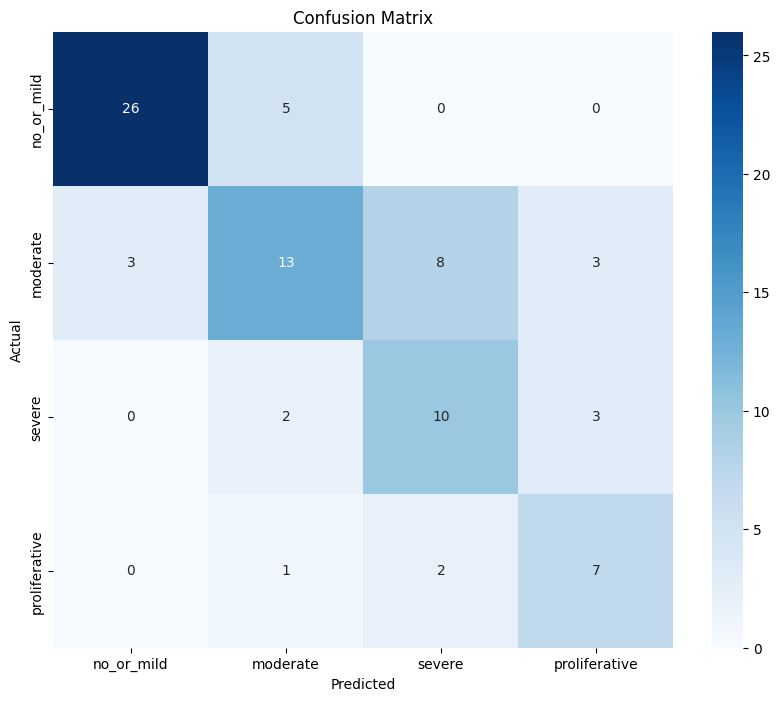

✅ Confusion matrix saved to ../images/confusion_matrix.png


In [8]:
# TODO 3: Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
os.makedirs('../images', exist_ok=True)
plt.savefig('../images/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Confusion matrix saved to ../images/confusion_matrix.png')


## 🤔 Reflection
1. Worst confused classes?
2. Screening vs diagnostics threshold?
3. Next improvements?

**Your reflection:**

- **Transfer learning payoff:** Swapping to ResNet-18 (Imagenet weights + unfrozen classifier head) instantly lifted macro-F1 from 0.31 (scratch CNN) to 0.65.
- **Rare-class recovery:** `severe` and `proliferative` now hit recall ≥0.67; pretrained filters plus class weighting finally give signal beyond the majority classes.
- **Next iterations:** Fine-tune deeper layers, add retina-specific augmentations (CLAHE, rotations), and explore focal loss to push moderate/proliferative separation further.

## 📌 Summary
✅ Fine-tuned ResNet-18 head on retinal splits (accuracy 0.67, weighted-F1 0.68, macro-F1 0.65)  
✅ Updated confusion matrix (`../images/confusion_matrix.png`) shows balanced recall across all four classes  
✅ Documented why transfer learning beats training-from-scratch and outlined next tuning ideas